In [1]:
import diplib as dip
import numpy as np

DIPlib -- a quantitative image analysis library
Version 3.4.1 (Oct 13 2023)
For more information see https://diplib.org


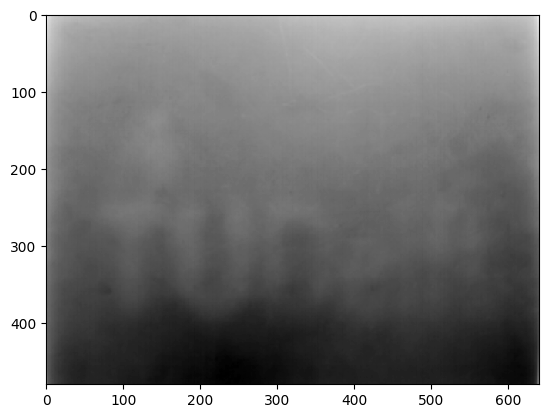

AttributeError: module 'diplib.PyDIPviewer' has no attribute 'View'

In [2]:
data = "opname1.ics"
imgs = dip.ImageReadICS(data)
imgs.SetPixelSize(1,"px")

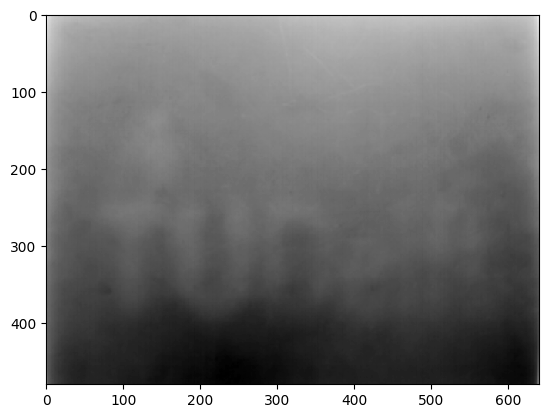

In [4]:
imgs.Show()
dip.viewer.Show(imgs)

In [5]:
# Highpass filter creation
temp1 = dip.Image([640,480],dt="SFLOAT")
temp1.Fill(0)
for i in range(imgs.Sizes()[2]):
    temp1 = temp1 + imgs[:,:,i]
    if i % 1000 == 0:
        print(i)
        
temp1 = temp1/imgs.Sizes()[2]
temp1.Squeeze()
low_pass = dip.Gauss(temp1,sigmas=[40,40]) # Only one time needed to apply the blur

0
1000
2000
3000
4000
5000
6000
7000


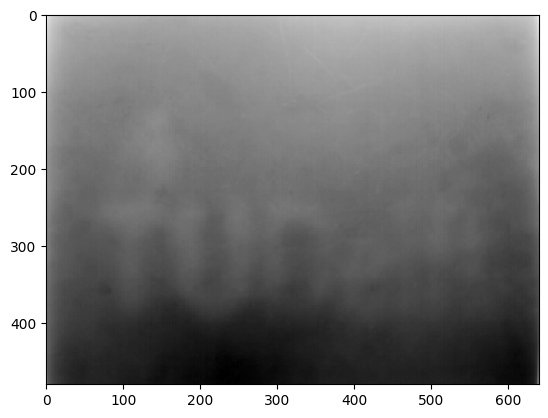

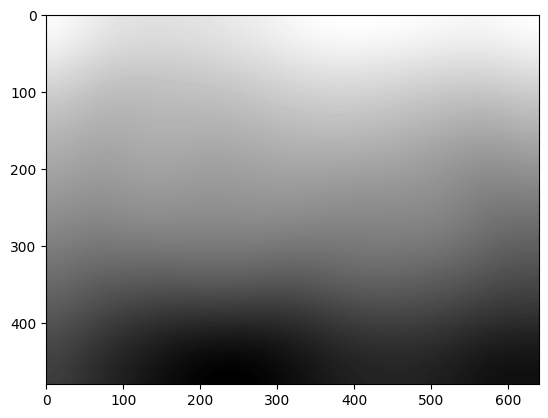

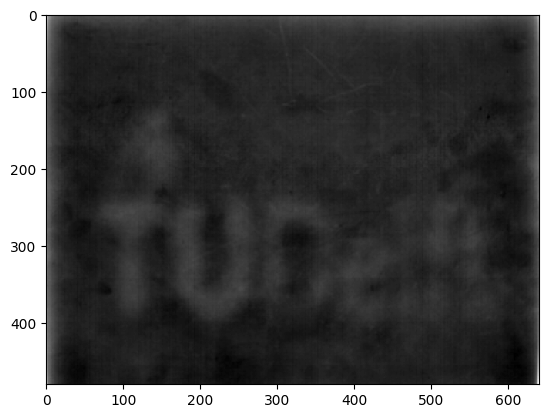

In [6]:
# Defining high_pass filter and checking results
high_pass = imgs - low_pass
temp1.Show()
low_pass.Show()
high_pass.Show()

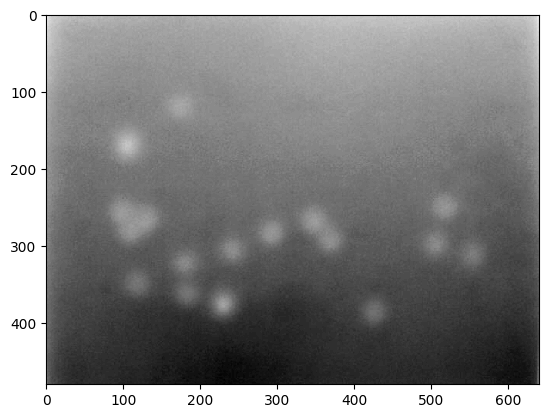

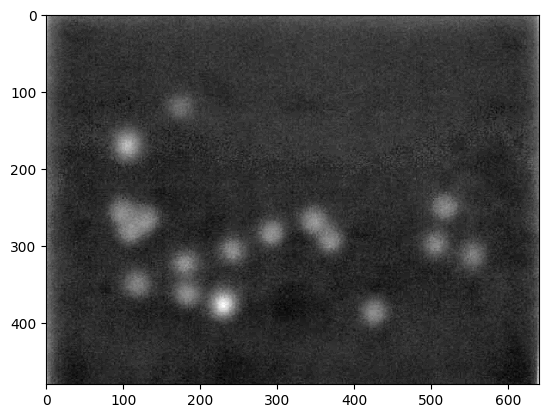

In [14]:
imgs[:,:,100].Show() # Checking results for a random slice
high_pass[:,:,100].Show()

In [8]:
# Smoothing the sides of blobs for more symmetrical emitters
smoothed_imgs=dip.Image([640,480,high_pass.Sizes()[2]])
for i in range(high_pass.Sizes()[2]):
    temp = dip.Copy(high_pass[:,:,i])
    temp.Squeeze()
    smoothed_imgs[:,:,i] = dip.Gauss(temp,sigmas=[5,5]) # For some reason smoothing without looping by using [5,5,0] gives
                                                        # a different output. A worse one.
    if i % 300 == 0:
        print(i)

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900


In [9]:
com = [] # Center of mass array, that will be used to store measurement data
for i in range(smoothed_imgs.Sizes()[2]):
    img_slice = dip.Copy(smoothed_imgs[:,:,i])
    img_slice.Squeeze()
    img_threshold = dip.IsodataThreshold(img_slice)
    img_mask = dip.Label(img_threshold,minSize=500)
    mentat = dip.MeasurementTool.Measure(img_mask,img_slice,features=["Eccentricity","Gravity","P2A"])
    for j in range(dip.Maximum(img_mask)[0][0]):
        if mentat["Eccentricity"][j+1][0] < 0.6 and mentat["P2A"][j+1][0]<1.2: #requirement to be a legitimate point
            com.append(mentat["Gravity"][j+1])
    if i%300==0:
        print(i)

0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900


In [10]:
scaling = 1 # Scaling factor option
round_com = np.round(scaling*np.array(com)).astype(int) #coordinates round to certain scaling of reconstruction img
print(round_com[0][0])
print(len(round_com)) # Checking the amount of valid localisations in the array

131
39275


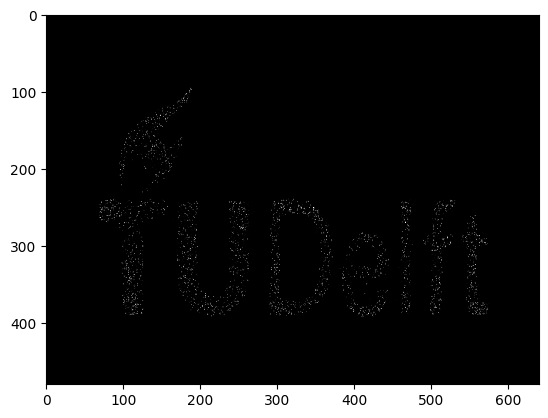

In [11]:
construct = dip.Image([scaling*640,scaling*480],dt="SFLOAT") # Empty image for reconstruction
construct.Fill(0)

for k in range(len(round_com)):
    try:
        x = round_com[k][0]
        y = round_com[k][1]
        if x >= 0 and x<=(scaling*640-1) and y>=0 and y<=(scaling*480-1):
            #easiest way to filter out weird "gravity" measurements
            construct[x,y] = (construct[x,y][0] + 1)
    except Exception as e:
        print(k)

construct.Show() # Without low-pass filter

In [12]:
#reconstruct = dip.ContrastStretch(construct,method="logarithmic"); initial ver of the filter
reconstruct = dip.Image([scaling*640,scaling*480])
reconstruct.Fill(0)
print(construct.Sizes())
for i in range(construct.Sizes()[0]):
    for j in range(construct.Sizes()[1]):
        reconstruct[i,j]=np.sqrt(construct[i,j][0]) # Adding a sqrt filter for smaller contrast and accuracy respresentation
    if i % 100==0:
        print(i)

[640, 480]
0
100
200
300
400
500
600


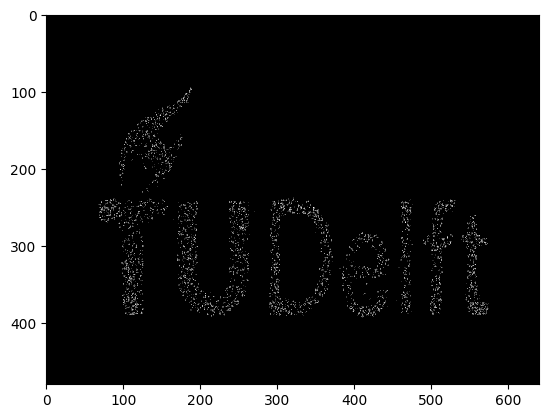

In [13]:
reconstruct.Show() # Final img

In [89]:
#dip.viewer.Show(imgs)

In [90]:
#dip.viewer.Show(temp1)

In [91]:
#dip.viewer.Show(temp1-low_pass)